In [4]:
import os
import sys
import torch
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import functional as F

# =========================
# SAM3 초기화 (이미 가지고 있다면 이 부분은 생략해도 됨)
# =========================
from sam3.model_builder import build_sam3_image_model
try:
    from sam3.sam3_utils import CustomSam3Processor as Sam3Processor
except ImportError:
    from sam3_utils import CustomSam3Processor as Sam3Processor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# BPE 경로는 네 환경에 맞게 조정
bpe_path = os.path.join("assets", "bpe_simple_vocab_16e6.txt.gz")
if not os.path.exists(bpe_path):
    alt = os.path.join(os.getcwd(), "sam3", "assets", "bpe_simple_vocab_16e6.txt.gz")
    if os.path.exists(alt):
        bpe_path = alt
if not os.path.exists(bpe_path):
    raise FileNotFoundError(f"BPE file not found: {bpe_path}")

sam3_model = build_sam3_image_model(bpe_path=bpe_path).to(device)
sam3_processor = Sam3Processor(sam3_model, confidence_threshold=0.3)


Device: cuda


In [9]:

# =========================
# L2 normalize
# =========================
def l2_normalize(x: torch.Tensor) -> torch.Tensor:
    return x / (x.norm(dim=-1, keepdim=True) + 1e-12)

# =========================
# SAM3 인코더로부터 이미지 임베딩 추출
# =========================
def sam3_image_embedding(image: Image.Image) -> torch.Tensor:
    """
    SAM3 encoder의 vision_features만 사용해서 이미지 임베딩 뽑기.
    - image: PIL.Image (RGB)
    - return: torch.Tensor [D]  (CPU, L2 normalized)
    """
    inference_state = sam3_processor.set_image(image)

    # inference_state 구조 확인용 (필요 없으면 주석 처리)
    # print("inference_state keys:", inference_state.keys())

    backbone_out = inference_state["backbone_out"]
    # backbone_out 구조 확인용
    # print("backbone_out keys:", backbone_out.keys())

    vision_features = backbone_out["vision_features"]   # torch.Size([1, 256, 72, 72])

    # device 올리기
    vision_features = vision_features.to(device)

    # [1, C, H, W] → [C] (공간 평균 풀링)
    # dim=[0,2,3] : batch, height, width 차원 평균
    pooled = vision_features.mean(dim=[0, 2, 3])  # [256]

    # L2 normalize 후 CPU 텐서로 반환
    emb = l2_normalize(pooled).cpu()
    # print("vision_features shape:", vision_features.shape)
    # print("pooled shape:", pooled.shape)
    # print("emb shape:", emb.shape)
    return emb



In [26]:
image_path = "../sample_images_from_kaggle/1.jpg"
image = Image.open(image_path).convert("RGB")

# sam3_image_embedding(image)

In [28]:
# =========================
# 이미지 폴더 인덱싱
# =========================
def build_sam3_vector_store(image_dir: str) -> list[dict]:
    exts = (".jpg", ".jpeg", ".png")
    image_paths = [
        os.path.join(image_dir, f)
        for f in os.listdir(image_dir)
        if f.lower().endswith(exts)
    ]

    vector_store = []
    print(f"Indexing {len(image_paths)} images from {image_dir} ...")

    for path in tqdm(image_paths):
        img = Image.open(path).convert("RGB")
        emb = sam3_image_embedding(img)  # [D]

        vector_store.append({
            "path": path,
            "embedding": emb,
        })

    print(f"Indexed {len(vector_store)} images.")
    return vector_store

# =========================
# 벡터스토어 저장/로드
# =========================
def build_sam3_vector_store(image_dir: str) -> list[dict]:
    exts = (".jpg", ".jpeg", ".png")
    image_paths = [
        os.path.join(image_dir, f)
        for f in os.listdir(image_dir)
        if f.lower().endswith(exts)
    ]

    vector_store = []
    print(f"Indexing {len(image_paths)} images from {image_dir} ...")

    for path in tqdm(image_paths):
        img = Image.open(path).convert("RGB")
        emb = sam3_image_embedding(img)  # [D]

        vector_store.append({
            "path": path,
            "embedding": emb,
        })

    print(f"Indexed {len(vector_store)} images.")
    return vector_store

In [7]:
from torch.nn import functional as F

def search_similar_sam3(query_image_path: str, vector_store, top_k: int = 5):
    print(f"Processing query image: {query_image_path}")
    query_img = Image.open(query_image_path).convert("RGB")
    query_emb = sam3_image_embedding(query_img)  # [D]

    scores = []
    for item in vector_store:
        db_emb = item["embedding"]  # [D]
        sim = F.cosine_similarity(
            query_emb.unsqueeze(0),
            db_emb.unsqueeze(0),
            dim=-1
        ).item()
        scores.append((sim, item["path"]))

    scores.sort(key=lambda x: x[0], reverse=True)
    top_k = min(top_k, len(scores))

    fig, axes = plt.subplots(1, top_k + 1, figsize=(4 * (top_k + 1), 4))

    # Query
    axes[0].imshow(query_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    # Top-k
    for i in range(top_k):
        sim, path = scores[i]
        img = Image.open(path).convert("RGB")
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{i+1}: {sim:.3f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [2]:
def save_vector_store(vector_store, path: str):
    with open(path, "wb") as f:
        pickle.dump(vector_store, f)
    print(f"Saved vector store to {path}")


def load_vector_store(path: str):
    with open(path, "rb") as f:
        vs = pickle.load(f)
    print(f"Loaded vector store from {path}, items: {len(vs)}")
    return vs

In [31]:
image_dir = "../data/images_original"
vs_path = "vector_store_sam3_encoder.pkl"

# 1) 인덱싱 (처음 한 번)
vector_store = build_sam3_vector_store(image_dir)
save_vector_store(vector_store, vs_path)


Indexing 5762 images from ../data/images_original ...


100%|██████████| 5762/5762 [18:35<00:00,  5.17it/s]


Indexed 5762 images.
Saved vector store to vector_store_sam3_encoder.pkl


Loaded vector store from vector_store_sam3_encoder.pkl, items: 5762
Processing query image: ../sample_images_from_kaggle/3.jpg


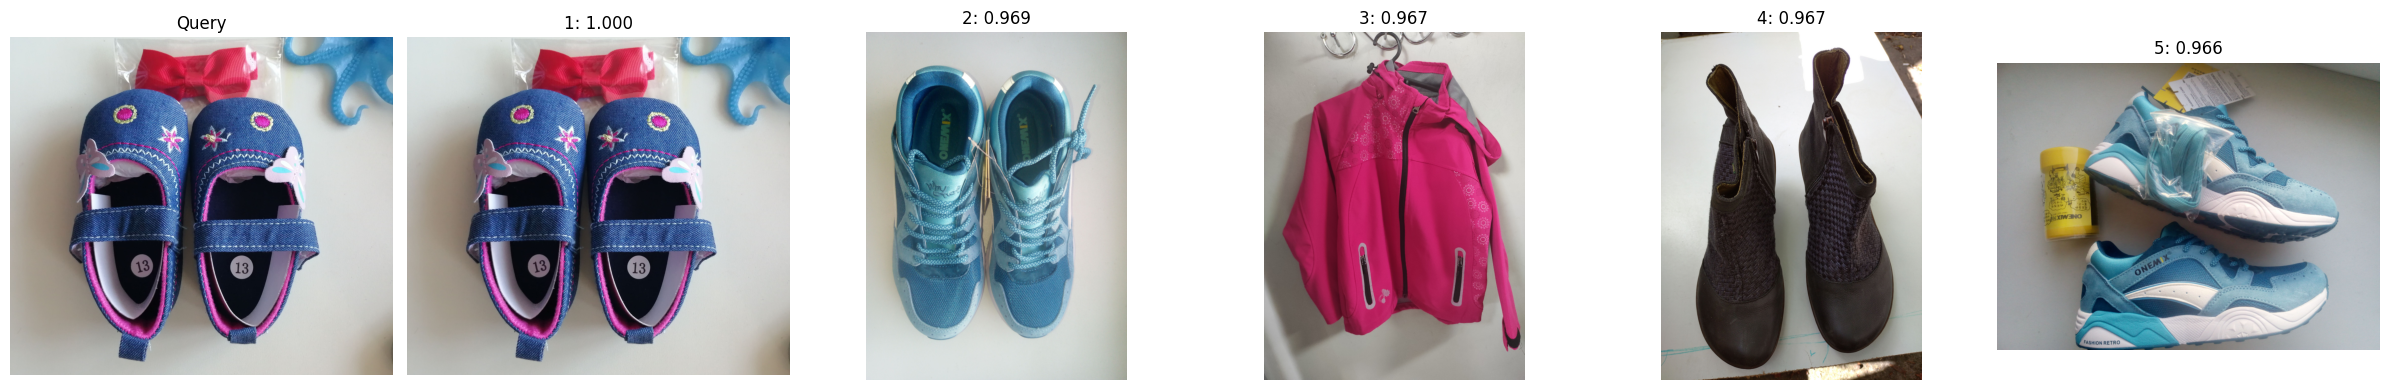

In [12]:
vs_path = "vector_store_sam3_encoder.pkl"
# 2) 이후에는 로드해서 바로 검색
vector_store = load_vector_store(vs_path)

query_image = "../sample_images_from_kaggle/3.jpg"
search_similar_sam3(query_image, vector_store, top_k=5)